In [1]:
import re
import pandas as pd

LOG_PATH = '../data/logfiles.log'
LOG_PATTERN = r'(?P<ip>\S+) - - \[(?P<time>[^\]]+)\] "(?P<method>\S+) (?P<endpoint>\S+) HTTP/\d\.\d" (?P<status>\d+) (?P<bytes>\d+) "(?P<referrer>[^"]+)" "(?P<ua>[^"]+)" (?P<response_time>\d+)'

def drop_data(df):
    """
    Drop unnesscary data
    
    It's all the same
    """
    return df.drop(["time", "referrer"], axis=1)

def parse_logs(path):
    data = []
    with open(path) as f:
        for line in f:
            match = re.match(LOG_PATTERN, line)
            if match:
                data.append(match.groupdict())
    
    return drop_data(pd.DataFrame(data))

df = parse_logs(LOG_PATH)
df.head()


,ip,method,endpoint,status,bytes,ua,response_time
0,78.227.234.134,GET,/usr,304,4994,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3)...,713
1,8.108.176.251,DELETE,/usr,303,5035,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,1906
2,3.173.150.154,GET,/usr/register,404,4983,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,3680
3,116.115.120.25,PUT,/usr,200,4924,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2788
4,160.26.158.113,PUT,/usr/admin,404,5043,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,793


In [2]:
from user_agents import parse
method_map = {
    "GET": 0,
    "DELETE": 1,
    "PUT": 2,
    "POST": 3
}
method_map2 = {
    "/usr": 0,
    "/usr/register": 1,
    "/usr/admin": 2,
    "/usr/admin/developer": 3,
    "/usr/login": 4
}
ua_parsed = df["ua"].apply(parse)
df["os"] = ua_parsed.apply(lambda x: x.os.family)
df["device"] = ua_parsed.apply(lambda x: x.device.family)
df["browser"] = ua_parsed.apply(lambda x: x.browser.family)
df["request_type_dummy"] = df["method"].map(method_map)
df["endpoint_dummy"] = df["endpoint"].map(method_map2)
df["status"] = df["status"].astype(int)
df["is_error"] = (df["status"] >= 400).astype(int)

In [3]:
os_dummies = pd.get_dummies(df['os'], prefix='os', drop_first=True).astype(int)
device_dummies = pd.get_dummies(df['device'], prefix='d', drop_first=True).astype(int)
browser_dummies = pd.get_dummies(df['browser'], prefix='b', drop_first=True).astype(int)


In [4]:
df

,ip,method,endpoint,status,bytes,ua,response_time,os,device,browser,request_type_dummy,endpoint_dummy,is_error
0,78.227.234.134,GET,/usr,304,4994,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3)...,713,Mac OS X,Mac,Safari,0,0,0
1,8.108.176.251,DELETE,/usr,303,5035,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,1906,Android,OnePlus ONEPLUS A6000,Chrome Mobile,1,0,0
2,3.173.150.154,GET,/usr/register,404,4983,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,3680,Android,OnePlus ONEPLUS A6000,Chrome Mobile,0,1,1
3,116.115.120.25,PUT,/usr,200,4924,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2788,Windows,Other,Opera,2,0,0
4,160.26.158.113,PUT,/usr/admin,404,5043,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,793,Windows,Other,Opera,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,176.113.252.35,GET,/usr/admin/developer,403,4995,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,2787,Android,OnePlus ONEPLUS A6000,Chrome Mobile,0,3,1
9996,81.8.116.146,POST,/usr/register,404,4983,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3020,Windows,Other,Chrome,3,1,1
9997,99.46.31.81,DELETE,/usr/login,500,4906,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1004,Windows,Other,Opera,1,4,1
9998,120.158.148.193,DELETE,/usr/admin/developer,403,4968,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2540,Windows,Other,Opera,1,3,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[["bytes", "response_time", "request_type_dummy", "endpoint_dummy"]]
y = df["is_error"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(max_depth=1, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.43      0.30      0.35       864
           1       0.57      0.70      0.63      1136

    accuracy                           0.52      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.51      0.52      0.51      2000



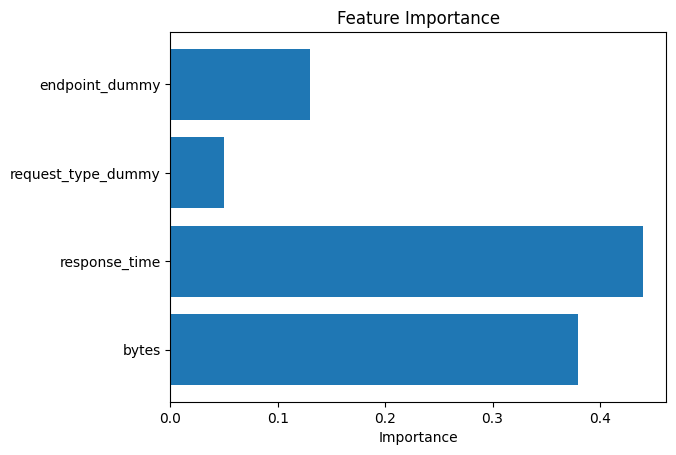

In [6]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
feature_names = X.columns

plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()


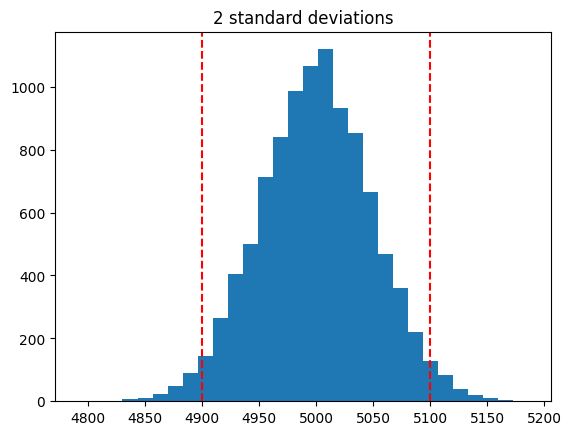

In [13]:
df["bytes"] = df["bytes"].astype(int)
plt.hist(df["bytes"], bins=30)
plt.axvline(x=4900, color='red', linestyle='--', label='4900')
plt.axvline(x=5100, color='red', linestyle='--', label='5100')
plt.title("2 standard deviations")
plt.show()

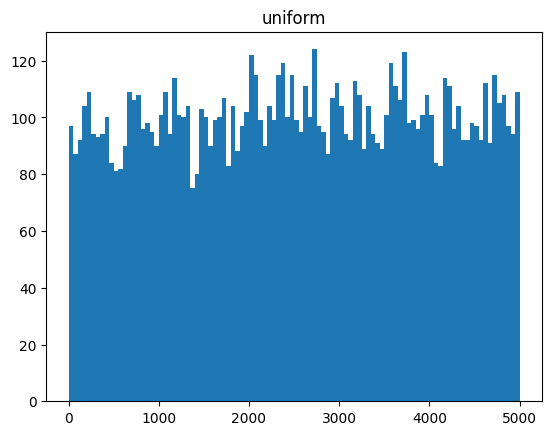

In [18]:
df["response_time"] = df["response_time"].astype(int)
plt.hist(df["response_time"], bins=100)
plt.title("uniform")
plt.show()